# Online Learning with SGD

Define run parameter (can be accessed by papermill)

In [1]:
FULL_RUN = False

## Load data

Kaggle [Avazu CTR Prediction challenge](https://www.kaggle.com/c/avazu-ctr-prediction)

Look at size of training set and number of lines. For this, use the following commands:

```bash
du -h train.csv
wc -l train.csv
```

We'll go through this data by "chunks". Let's set the size of a chunk (can be accessed by papermill):

In [2]:
CHUNK_SIZE = 1000 # small value for fast execution; can bump to 10000

Let's create a chunk "reader":

In [5]:
from mlxtend.utils.data import filename2path
from pandas import read_csv
TRAIN_FILE = filename2path("avazu")
HEADER = ['id','click','hour','C1','banner_pos','site_id','site_domain','site_category','app_id','app_domain','app_category','device_id'\
        ,'device_ip','device_model','device_type','device_conn_type','C14','C15','C16','C17','C18','C19','C20','C21']
reader = read_csv(TRAIN_FILE, chunksize=CHUNK_SIZE, names=HEADER, header=0)

Looking for DATA_PATH in environment variables
 Found it!
Looking for file at /data/avazu/train.csv ...
  Found it!


In [6]:
reader

There are about 4,000 chunks of size 10,000 in this data.

Let's look at the first chunk:

In [7]:
chunk = reader.get_chunk()
print("Chunk weighs " + str(chunk.memory_usage(index=True).sum()/(1024**2)) + " MB")

Chunk weighs 0.1832275390625 MB


In [8]:
chunk

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1000009418151094273,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,10000169349117863715,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,10000371904215119486,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,10000640724480838376,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,10000679056417042096,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10143043261436144411,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15708,320,50,1722,0,35,100084,79
996,1014322937494547310,0,14102100,1005,0,f282ab5a,61eb5bc4,f028772b,ecad2386,7801e8d9,...,1,0,20596,320,50,2161,0,35,-1,157
997,10143295888139735045,0,14102100,1005,0,030440fe,08ba7db9,76b2941d,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157
998,10143417277678185860,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15703,320,50,1722,0,35,-1,79


In [9]:
import qgrid
qgrid_widget = qgrid.show_grid(chunk, show_toolbar=True)
qgrid_widget

AttributeError: module 'pandas.core' has no attribute 'index'

## Prepare data

Let's create a function that

* Extracts inputs `X` and outputs `y` from a chunk dataframe
* Applies feature hashing to the inputs (here, using $2^{20}$ features)

In [10]:
from numpy import asarray
from sklearn.feature_extraction import FeatureHasher
fh = FeatureHasher(n_features=2**20, input_type='string')

def chunk2Xy(chunk):
    y = chunk['click'].values
    X = chunk.drop(['id', 'click'], axis=1) # remove id and target columns
    X = fh.transform(asarray(X.astype(str))) # transform X to array of strings, so we can apply feature hashing
    return X, y

Test this function:

In [11]:
chunk2Xy(reader.get_chunk())

(<1000x1048576 sparse matrix of type '<class 'numpy.float64'>'
 	with 20394 stored elements in Compressed Sparse Row format>,
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## Set model hyper-parameters

We'll use the first INIT_SIZE lines of the dataset as training data to tune hyper-parameters:

* SGD parameters: learning rate and number of epochs
* model parameters: regularization
* featurization parameters: number of features

Re-set `reader` so we start reading from the beginning of the dataset:

In [12]:
reader = read_csv(TRAIN_FILE, chunksize=CHUNK_SIZE, names=HEADER, header=0)

Choose INIT_SIZE so that training data fits in memory and search isn't too long (can be accessed by papermill):

In [13]:
INIT_SIZE = 100000 # small value for fast execution; can bump to 1000000

In [14]:
chunk_init = reader.get_chunk(INIT_SIZE)

In [15]:
print("Chunk weighs " + str(chunk_init.memory_usage(index=True).sum()/(1024**2)) + " MB")

Chunk weighs 18.3106689453125 MB


Hyper-parameter tuning...

In [16]:
# look at output distribution
# split X, y into train and val sets
# fit on train
# compute accuracy on val set

In [17]:
1-sum(chunk_init['click'].values)/len(chunk_init['click'].values)

0.8251

In [18]:
from sklearn.model_selection import train_test_split
X, y = chunk2Xy(chunk_init)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(loss='log', random_state=42, max_iter=100)
classes = [0, 1]
model.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=100,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [20]:
from sklearn import metrics
y_pred_val = model.predict(X_val)
y_pred_proba_val = model.predict_proba(X_val)
print("Accuracy: " + str(metrics.accuracy_score(y_val, y_pred_val)))
print("F-measure: " + str(metrics.f1_score(y_val, y_pred_val)))
print("log-loss: " + str(metrics.log_loss(y_val, y_pred_proba_val)))

Accuracy: 0.82895
F-measure: 0.26128266033254155
log-loss: 0.40538326988361373


## Fit model chunk-by-chunk

Let's iterate over the chunk reader, update our model with every new chunk, and display logloss every K chunks.

Let's set K to 100 and initialize a variable to store loss values every K chunks

In [21]:
K = 100
chunk_indices_processed = []
losses_Kchunks = []
# print("The number of loss values will grow in size from 0 to " + N/(CHUNK_SIZE*K))
print("Each loss value will be computed over " + str(CHUNK_SIZE*K) + " data points")

Each loss value will be computed over 100000 data points


Initialize variables to store outputs and predictions for these data points:

In [22]:
y_Kchunks = []
y_pred_Kchunks = []
y_pred_no_update_Kchunks = []

Define a function that plots the loss:

In [23]:
from IPython.display import clear_output
from pandas import DataFrame
import matplotlib.pyplot as plt

def display_loss():
    clear_output()
    DataFrame({'linear_regression': losses_Kchunks}).plot()
    plt.xlabel('Number of times (K chunks) were processed (K=' + str(K) + ')')
    plt.ylabel('Log-loss')
    plt.show()

Iterate on `reader`, apply model to new chunk so we can update `y_pred_Kchunks`, and then update it using the new chunk.

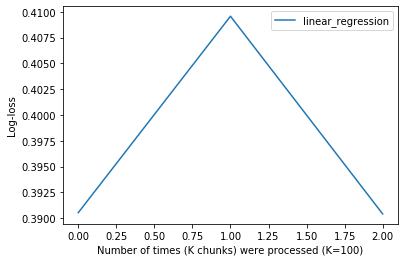

In [24]:
from sklearn.metrics import log_loss

for c, chunk in enumerate(reader): # c is a chunks counter

    X, y = chunk2Xy(chunk)
    
    # Compute loss over the last K chunks
    # Step 1. Update lists of outputs and predictions at every chunk
    y_Kchunks.extend(y)
    y_pred_Kchunks.extend(model.predict_proba(X))
    # Step 2. Every K chunks...
    if (c % K == 0):
        # Display loss over the last K chunks
        chunk_indices_processed.append(c)
        losses_Kchunks.append(log_loss(y_Kchunks, y_pred_Kchunks))
        # losses_Kchunks_no_update.append(log_loss(y_Kchunks, y_pred_no_update_Kchunks))
        display_loss()
        
        # Reset lists of outputs and predictions used to compute loss
        y_Kchunks = []
        y_pred_Kchunks = []
        # y_pred_no_update_Kchunks = []

    model.partial_fit(X, y, classes=classes) # this runs only 1 epoch; try more?

    # if not doing a full run, stop loop after 2*K chunks
    if (not FULL_RUN and c==2*K):
        break